# Python imports

In [1]:
import csv, time
import numpy as np
import multihash as mh
import hashlib as hl
import matplotlib.pyplot as plt
from binary_trie import Trie, bytes_to_bitstring, int_to_bitstring

# Plot design

In [2]:
plt.rc('font', size=20)

# Helper functions and classes

In [3]:
def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

def xor_bitstring(bs0: str, bs1: str) -> str:
    s = ""
    if len(bs0) == len(bs1):
        for i in range(len(bs0)):
            if bs0[i]==bs1[i]:
                s+='0'
            else:
                s+='1'
    return s

# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


In [4]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors_ids):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors_ids = neighbors_ids
        
        self.key = multihash_to_kad_id(peer_id)
        
        self.alive = len(neighbors_ids)>0
        
        self.buckets = [[] for _ in range(257)]
        self.neighbors = {}
        
    def distance(self, p):
        return xor_distance(self.key, p.key)
        
    def addNeighbor(self, peer):
        if bytes_to_bitstring(peer.key) not in self.neighbors:
            self.neighbors[bytes_to_bitstring(peer.key)]=(peer)
            self.buckets[bucket_number_for_distance(self.distance(peer))].append(peer)
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors_ids)


# Gathering data for plots

## Global variables used to collect data from the crawls before plotting it

In [69]:
routing_table_distribution_in_kbuckets_data = [[] for _ in range(257)]

In [70]:
peerids_distribution_data = []
peerids_distribution_chunk88_data = [] # 1011000

In [71]:
closest20_cdf_data = []

In [72]:
missing_peers_per_bucket_data = []
missing_peers_per_non_full_bucket_data = []

In [73]:
closest_peers_data = [[] for _ in range(20)]

## Routing table distribution in the k-buckets

In [74]:
def routing_table_distribution_in_kbuckets(peers):
    # creating empty buckets
    buckets=[[] for _ in range(257)]

    # aggregating the number of entries per bucket for all peers
    for pid in peers:
        p=peers[pid]
        if p.alive:
            for i in range(len(p.buckets)):
                routing_table_distribution_in_kbuckets_data[i].append(len(p.buckets[i]))

In [75]:
levels=7

def peerids_distribution(peers):
    # getting the list of bitstrings for the given peerids
    peerids = [bytes_to_bitstring(peers[p].key) for p in peers]
    
    trie = Trie()
    for p in peerids:
        trie.add(p)
        
    density=[0] * 2**levels

    for i in range(2**levels):
        path="{0:b}".format(i)           # getting binary number
        path='0'*(levels-len(path))+path # zero padding for constant size bitstring

        density[i]=trie.find_trie(path).size
        
    peerids_distribution_data.append(density)
    
    levels88 = 4
    density88 = [0] * 2**levels88
    for i in range(2**levels88):
        path="{0:b}".format(i)           # getting binary number
        path='0'*(levels88-len(path))+path # zero padding for constant size bitstring
        path=int_to_bitstring(88,7)+path

        for p in peerids:
            if p[:len(path)] == path:
                density88[i]+=1
                
        
    peerids_distribution_chunk88_data.append(density88)

    """
    THIS NEEDS TO HAVE A Trie.find_trie_or_child(key) FUNCTION OR Trie.subtrie_size(key) / Trie.keys_with_prefix()
    
    levels88 = 2
    density88 = [0] * 2**levels88
    for i in range(2**levels88):
        path="{0:b}".format(i)           # getting binary number
        path='0'*(levels-len(path))+path # zero padding for constant size bitstring
        path=int_to_bitstring(88,7)+path
        
        node = trie.find_trie(path)
        density88[i]= 0 if node is None else node.size
        
    peerids_distribution_chunk88_data.append(density88)
    """


In [76]:
def closest20_cdf(peers, all_peers, trie):
    neighbors20 = []
    for p in peers:
        peers20 = trie.n_closest(bytes_to_bitstring(peers[p].key), 21)[1:]
        # peerset20 = t.n_closest(bytes_to_bitstring(alive_peers[p].key), 21)[1:] # that is wrong
        # we should test the actual neighbors e.g peers[p].neighbors
        neighbors = [all_peers[p].neighbors[n].key for n in all_peers[p].neighbors]

        count = 0
        for p in peers20:
            if p.key in neighbors:
                count+=1
        neighbors20.append(count)

    closest20_cdf_data.append(neighbors20)

In [77]:
def missing_peer_in_buckets(peers, trie): # TODO: pass parameter and rename variables
    non_full_buckets = [0] * 255
    missing_peers_in_bucket = [0] * len(non_full_buckets)

    for p in peers:
        for bid in range(len(non_full_buckets)):
            blen = len(peers[p].buckets[bid])
            if blen < 20:
                non_full_buckets[bid] += 1

                # bucket number = CPL
                key = bytes_to_bitstring(peers[p].key)
                path = key[:bid]+str(1-int(key[bid+1]))

                subtrie = trie.find_trie(path)
                if subtrie is None:
                    # we want to find out if it is included in a path
                    # or if it is not present at all in the trie
                    subtrie = trie
                    while len(subtrie.key) < len(path):
                        subtrie = subtrie.branch[int(path[len(subtrie.key)])]
                        m = min(len(path),len(subtrie.key)+1)
                        if subtrie.key[:m] != path[:m]:
                            # subtrie doesn't exist
                            subtrie = None
                            break

                if subtrie is not None and subtrie.size > blen:
                    missing_peers_in_bucket[bid] += min(subtrie.size,20) - blen
                    
    missing_peers_per_bucket_data.append([missing_peers_in_bucket[i]/len(peers) for i in range(len(non_full_buckets))])
    missing_peers_per_non_full_bucket_data.append([missing_peers_in_bucket[i]/non_full_buckets[i] if non_full_buckets[i] > 0 else 0 for i in range(len(non_full_buckets))])
                


In [78]:
def closest20_bucket_distribution(peers, all_peers, trie):
    for p in peers:
        # get 20 closest neighbors from the trie
        closest20 = trie.n_closest(bytes_to_bitstring(all_peers[p].key), 21)[1:]

        for i in range(len(closest20)):
            d=xor_distance(peers[p].key, closest20[i].key)
            bucket=bucket_number_for_distance(d)

            closest_peers_data[i].append(bucket)


# Loading data exctracted from the Nebula Crawler DB

- `nebula_peerids` is a mapping from the Nebula ID to the peer ID for all hosts observed by Nebula over the time period `2022-02-16 10:30:01.706317+01` to `2022-05-03T13:01:17.238Z`

- `all_crawls` is a list of `[crawl_id, nebula_id, peer_id, neighbor0, neighbor1, ... neighborN]` for all diable peers for the selected crawls.

In [79]:
with open("data/all-peerids.csv", 'r') as file:
    nebula_peerids = {line[0]:line[1] for line in csv.reader(file)}

In [80]:
filename = "data/nebula-peers-2crawls.csv"

In [81]:
with open(filename, 'r') as file:
    all_crawls = [line for line in csv.reader(file)]

In [82]:
crawl_id = all_crawls[0][0]
peers = {}
startTime = time.time()

for i in range(len(all_crawls)):
    entry = all_crawls[i]
        
    # add entry to peers
    peers[entry[1]] = NebulaPeer(entry[1], entry[2], entry[3:])

    if i == len(all_crawls)-1 or all_crawls[i+1][0] != crawl_id:
        # do all computations for the crawl
        print("Crawl", crawl_id, ":", len(peers),"alive peers crawled, time elapsed:", time.time() - startTime)
                
        # stale peers count
        stale_count = 0
        all_peers = peers.copy()
        # define neighbor relationships
        for p in peers:
            for n in peers[p].neighbors_ids:
                if n in peers:
                    peers[p].addNeighbor(peers[p])
                else:
                    stale_count += 1
                    all_peers[n] = NebulaPeer(n, nebula_peerids[n], [])
                all_peers[p].addNeighbor(all_peers[n])
                
        t = Trie()
        for p in peers:
            t.add(bytes_to_bitstring(peers[p].key), metadata=peers[p])
        print("Done with data structures", time.time() - startTime)
                
        routing_table_distribution_in_kbuckets(all_peers)
        closest20_cdf(peers, all_peers, t)
        missing_peer_in_buckets(peers, t) # takes a lot of time (~45 sec)
        peerids_distribution(all_peers)
        closest20_bucket_distribution(peers, all_peers, t)
            
        print("Crawl", crawl_id, "finished, stale peers:", stale_count,", total time elapsed:", time.time() - startTime)
        
        # reset variables for next crawl
        if i < len(all_crawls) - 1:
            peers = {}
            crawl_id = all_crawls[i+1][0]
            startTime = time.time()
        

Crawl 3518 : 16837 alive peers crawled, time elapsed: 0.4711894989013672
Done with data structures 134.49689745903015
Crawl 3518 finished, stale peers: 166782 , total time elapsed: 186.51908683776855
Crawl 3519 : 16908 alive peers crawled, time elapsed: 0.45783495903015137
Done with data structures 122.58394742012024
Crawl 3519 finished, stale peers: 164699 , total time elapsed: 173.3100175857544


# Plots

## Routing table distribution in the k-buckets

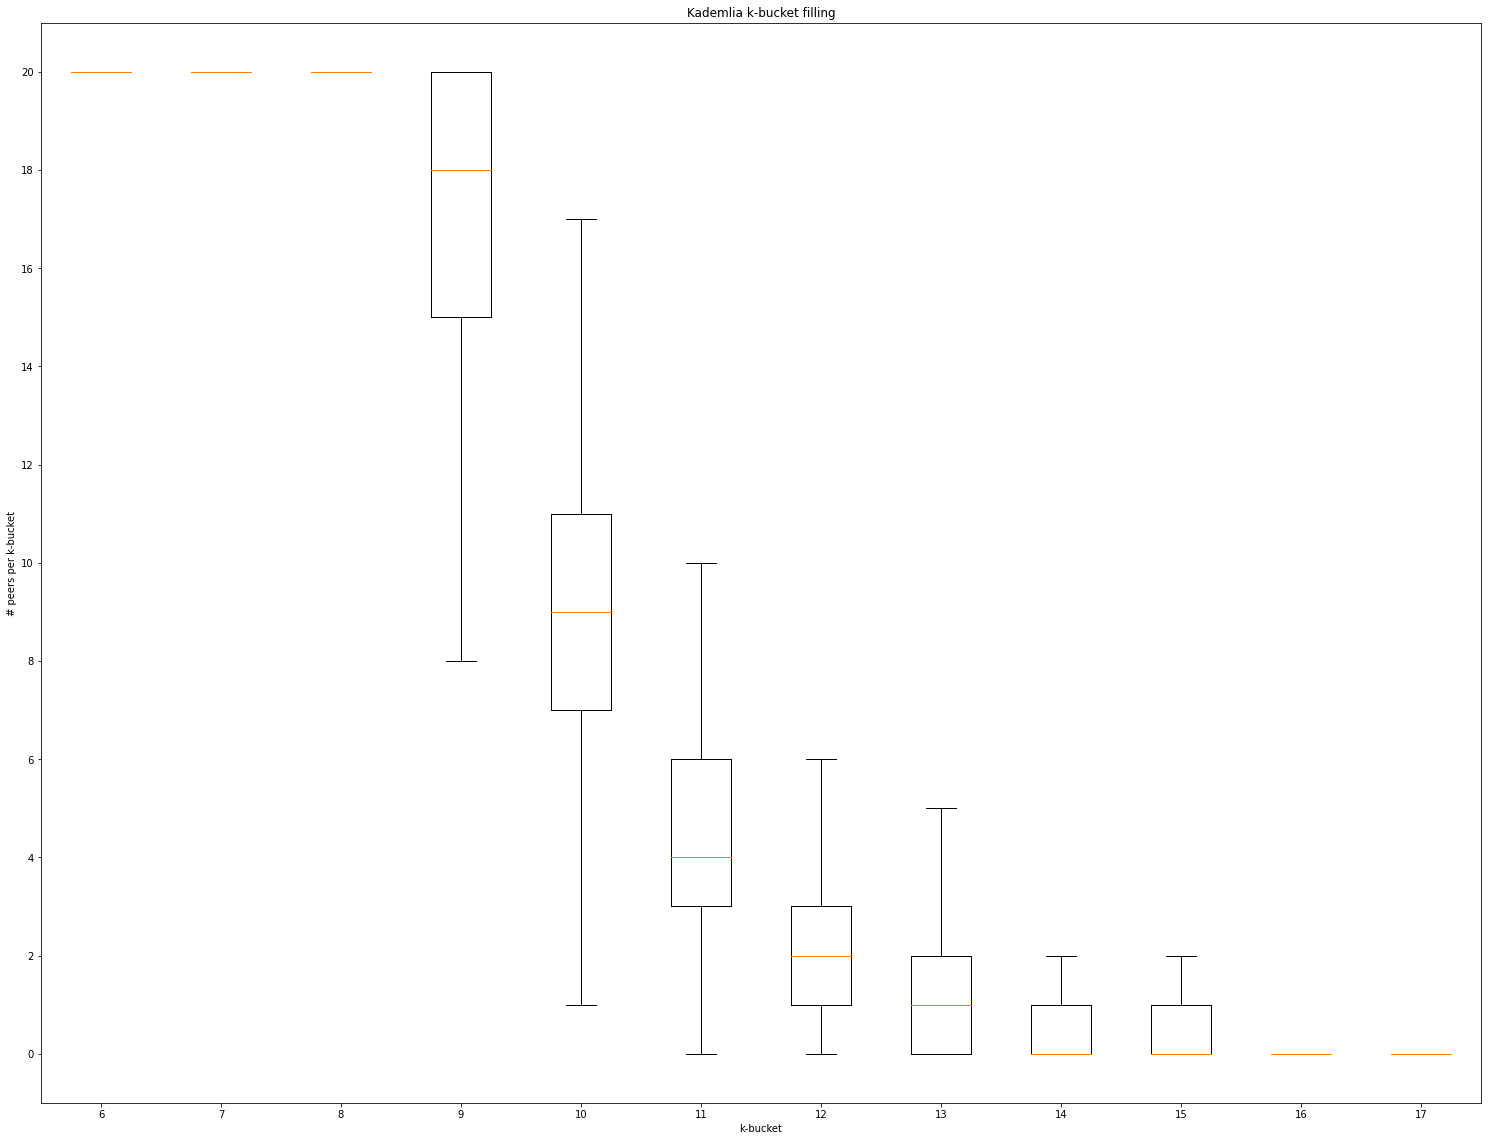

In [83]:
fig = plt.figure(figsize=(20,15), facecolor='white', edgecolor ='black')
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
plt.yticks(range(0, 21, 2))


bp = ax.boxplot(routing_table_distribution_in_kbuckets_data[6:18], positions=range(6,18), showfliers=False)

plt.xlabel("k-bucket")
plt.ylabel("# peers per k-bucket")
plt.grid(False)

plt.title("Kademlia k-bucket filling")

plt.savefig("plots/kbucket-filling-distribution-test.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

In [84]:
closest20_average = []
for data in closest20_cdf_data:
    closest20_average += data

In [85]:
closest20_pdf = [closest20_average.count(x)/len(closest20_average) for x in range(21)]
closest20_cdf = [sum(closest20_pdf[:i+1]) for i in range(len(closest20_pdf))]

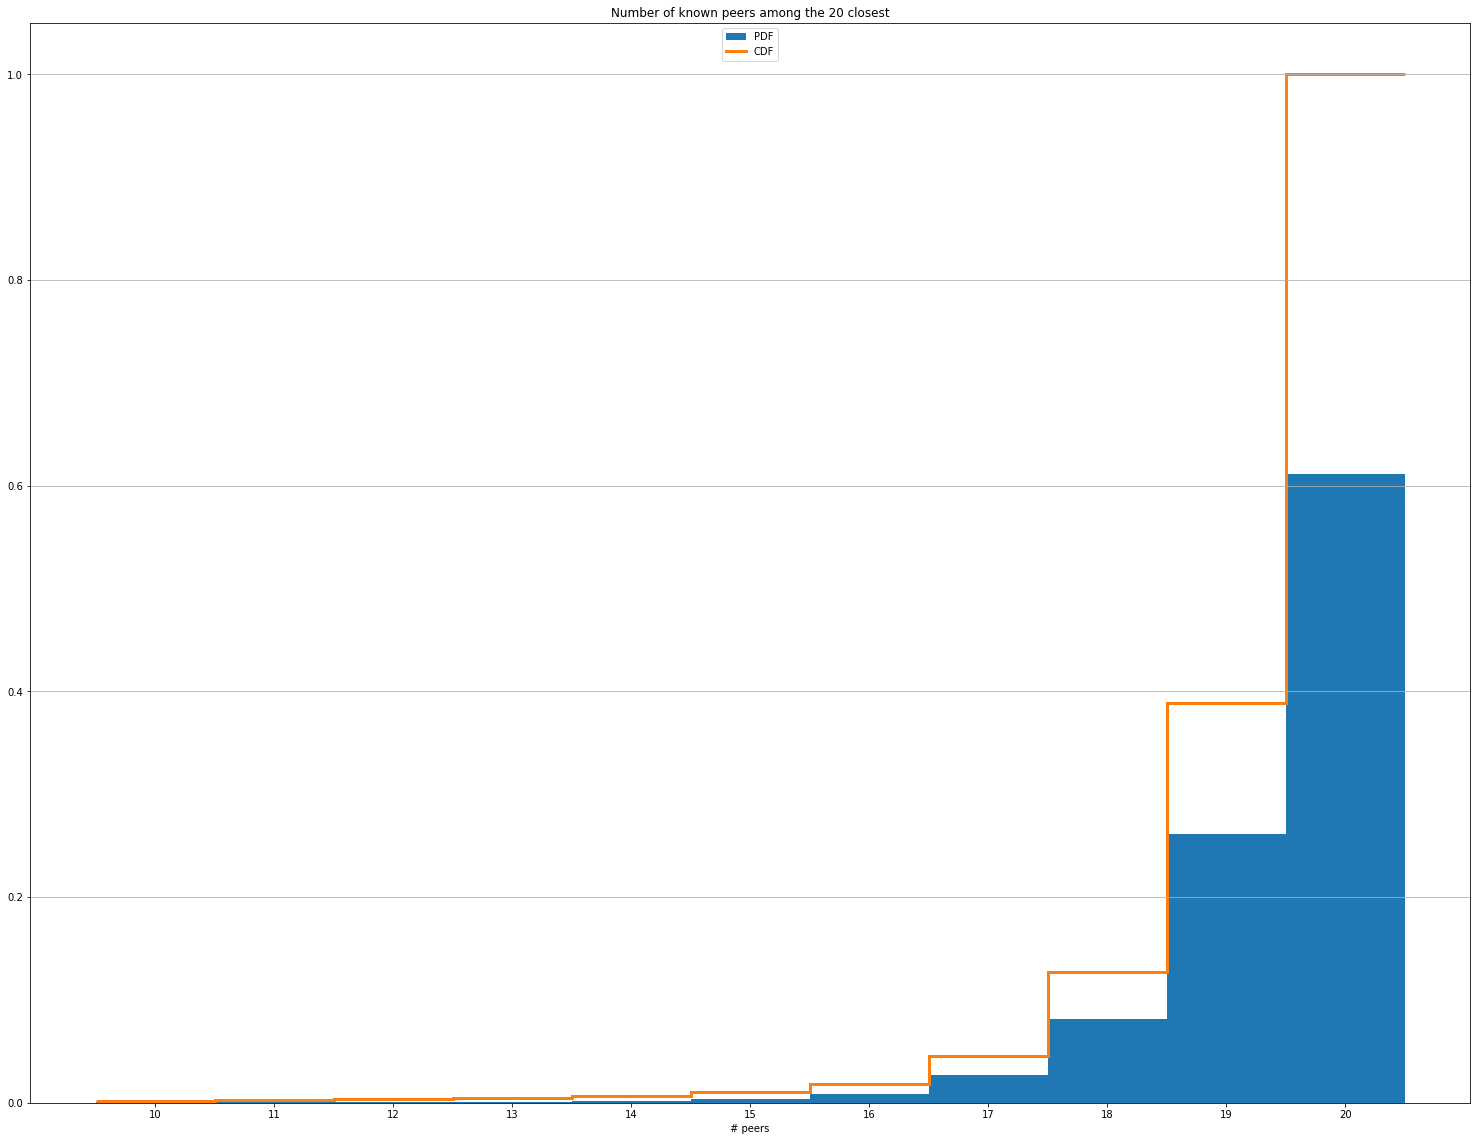

In [86]:
fig = plt.figure(figsize=(20,15), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

ax.stairs(values=closest20_pdf[10:], edges=[x - 0.5 for x in range(10, 22)], label='PDF', fill=True)
ax.stairs(values=closest20_cdf[10:], edges=[x - 0.5 for x in range(10, 22)], label='CDF', linewidth=3, baseline=None)

plt.grid(axis='y')
plt.xlabel("# peers")
plt.xticks(range(10, 21))
plt.legend(loc='upper center')
plt.title("Number of known peers among the 20 closest")
plt.savefig('plots/known-peers-among-20-closest-new.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [87]:
missing_peers_per_bucket_avg = np.average(missing_peers_per_bucket_data, axis=0)
missing_peers_per_non_full_bucket_avg = np.average(missing_peers_per_non_full_bucket_data, axis=0)
avg_in_bucket= np.average(routing_table_distribution_in_kbuckets_data, axis=1)

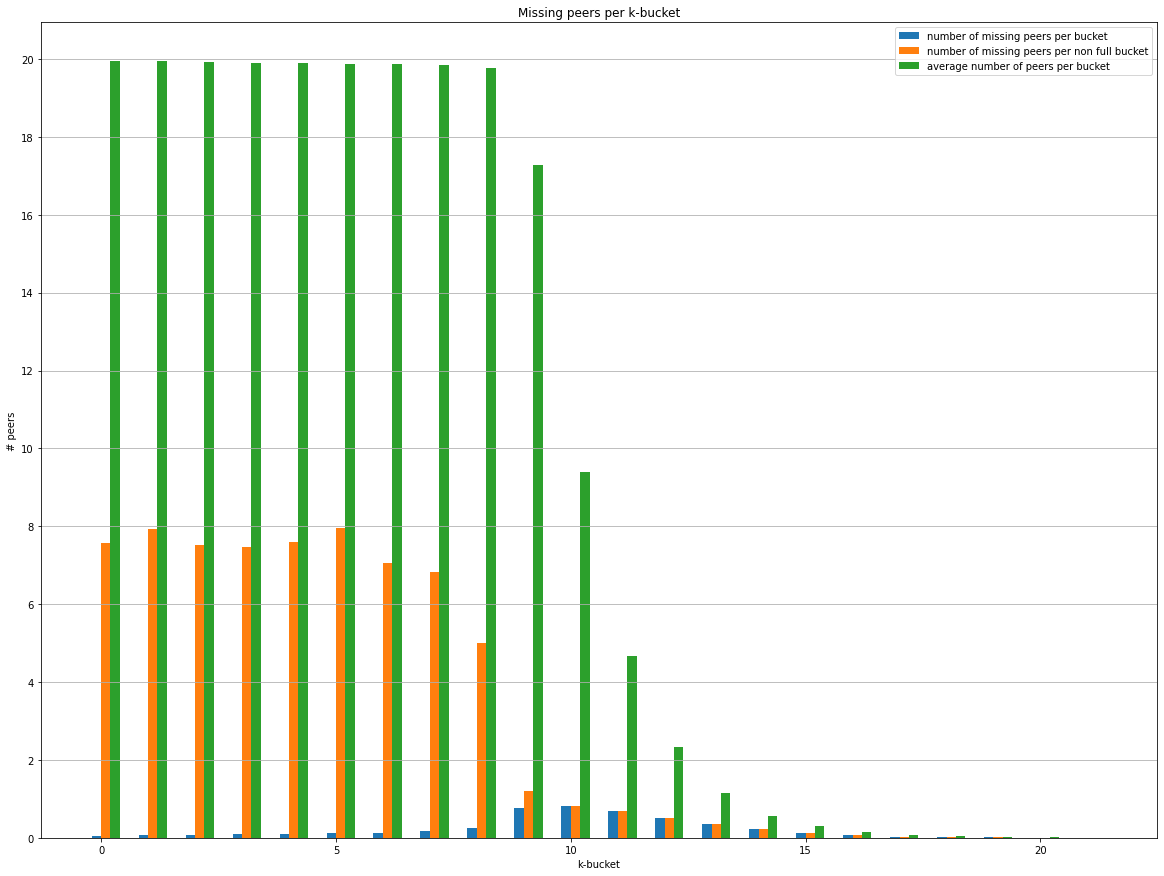

In [88]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.yticks(range(0, 22, 2))

plt.grid(axis='y')
plt.bar([x - 0.1 for x in range(22)], missing_peers_per_bucket_avg[:22], width=0.2, label='number of missing peers per bucket')
plt.bar([x + 0.1 for x in range(22)], missing_peers_per_non_full_bucket_avg[:22], width=0.2, label='number of missing peers per non full bucket')
plt.bar([x + 0.3 for x in range(22)], avg_in_bucket[:22], width=0.2, label='average number of peers per bucket')

#plt.bar(range(22), missing_peers_per_non_full_bucket[:22], width=0.25)

#plt.bar([x+232 for x in range(len(ratio_bucket[232:]))], ratio_bucket[232:], width=0.25)

plt.title('Missing peers per k-bucket')
plt.xlabel("k-bucket")
plt.ylabel("# peers")
plt.legend()

plt.savefig('plots/missing-peers-new.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [89]:
closest_peers_avg = []
for line in closest_peers_data:
    closest_peers_avg.append(sum(line)/len(line))

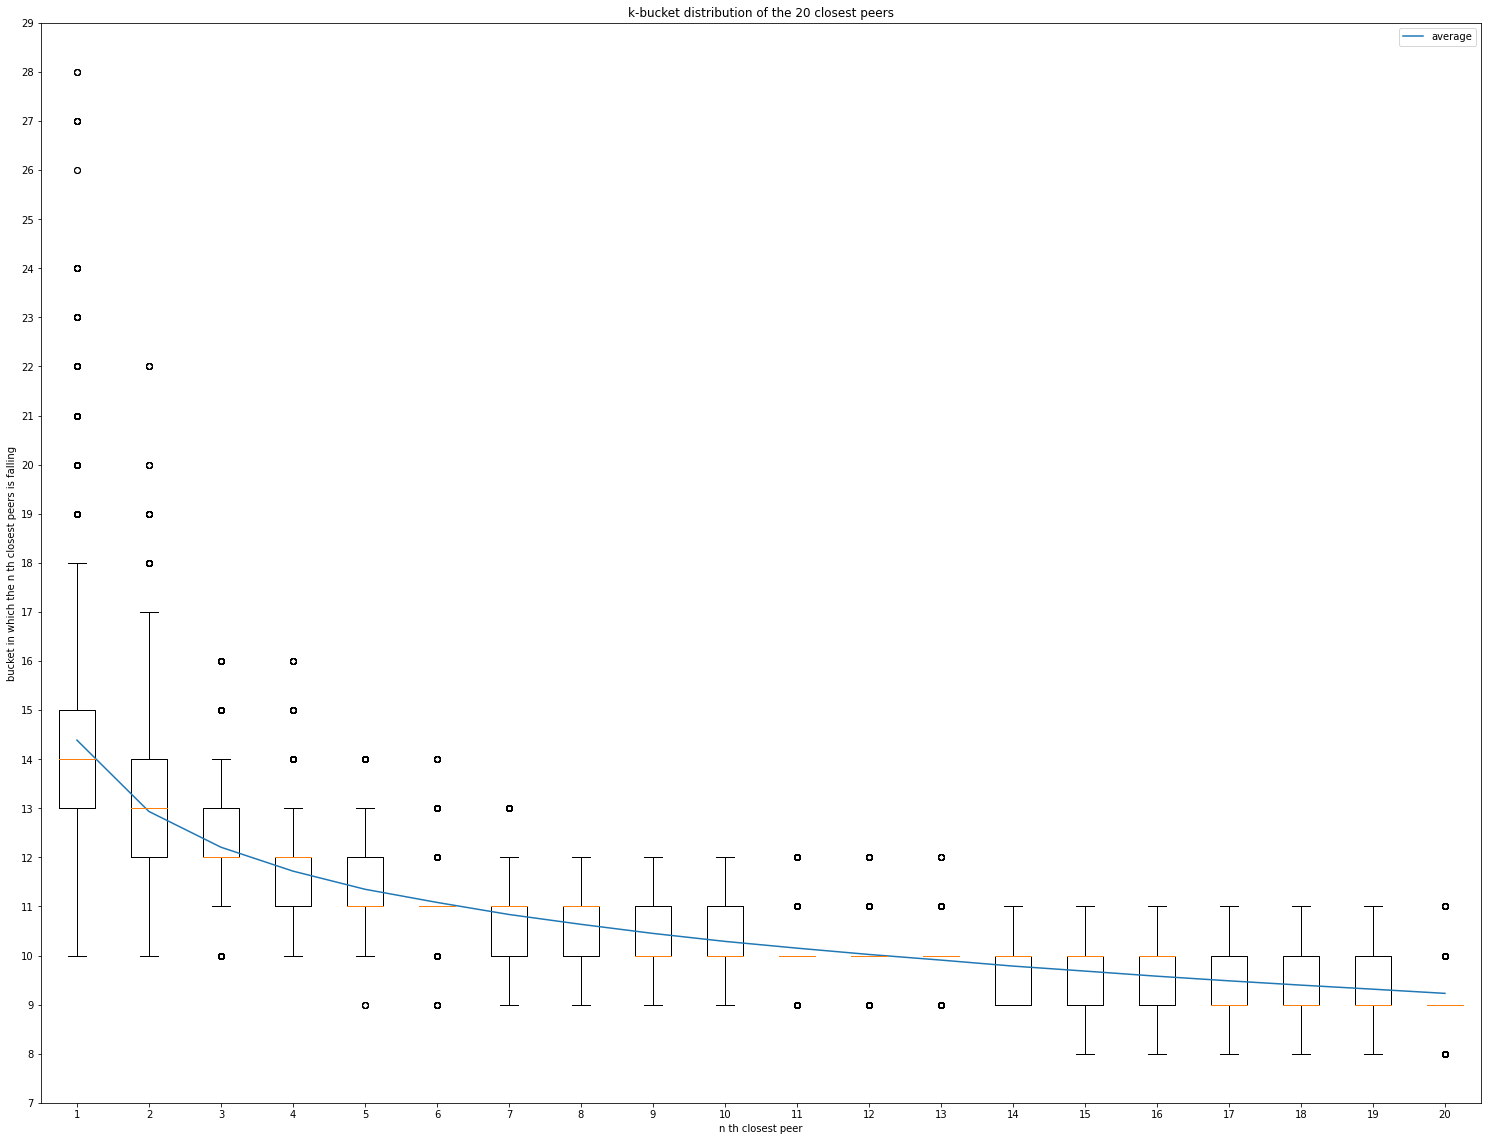

In [90]:
fig = plt.figure(figsize=(20,15), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

plt.yticks(range(5, 31, 1))

plt.grid(False)
plt.xlabel("n th closest peer")
plt.ylabel("bucket in which the n th closest peers is falling")

#plt.title("IPFS network: Kademlia k-bucket filling")

bp = ax.boxplot(closest_peers_data)
ax.plot(range(1,21),closest_peers_avg, label='average')

plt.legend()
plt.title("k-bucket distribution of the 20 closest peers")
 
plt.savefig('plots/kbucket-distribution-20-closest-peers-new.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

In [91]:
xClosest = []
for i in range(len(closest_peers_data)):
    total=sum([closest_peers_data[i].count(b) for b in range(9,26)])
    xClosest.append([closest_peers_data[i].count(b)/total for b in range(9,26)])

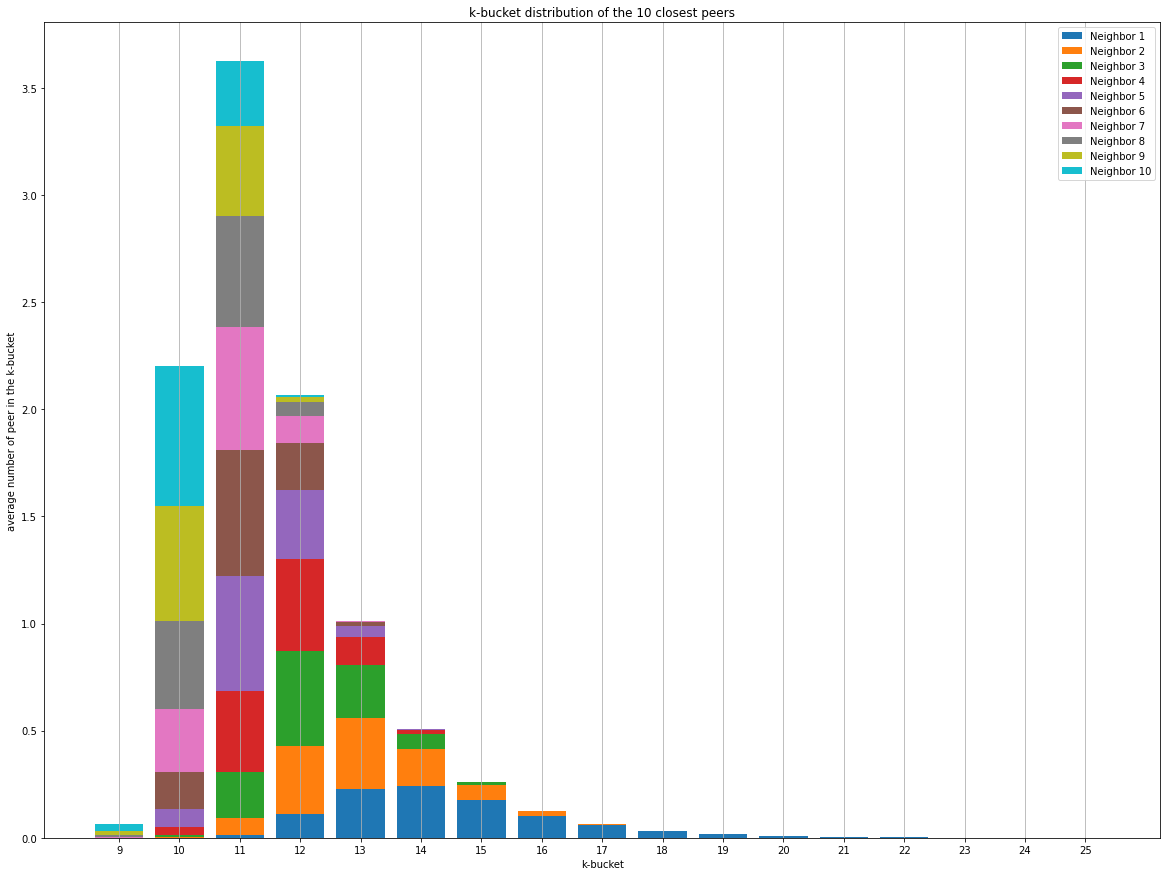

In [92]:
fig, ax = plt.subplots(figsize=(20,15), facecolor='white')

plt.xticks(range(9, 26, 1))

cumsum=[0 for _ in range(9,26)]

for i in range(10):
    label="Neighbor "+str(i+1)
    ax.bar(range(9,26), xClosest[i], bottom=cumsum, label=label)        
    cumsum = [cumsum[j]+xClosest[i][j] for j in range(len(cumsum))]
    
ax.legend()
plt.grid(axis='x')

plt.title("k-bucket distribution of the 10 closest peers")
plt.xlabel("k-bucket")
plt.ylabel("average number of peer in the k-bucket")
plt.savefig('plots/distribution-10-closest-peers.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

# PeerID distribution

Odd distribution peak with prefix _10110001001_

In [43]:
density = np.average(peerids_distribution_data, axis=0)

In [44]:
print("Average:            ", round(np.average(density),2))
print("Standard deviation:  ", round(np.std(density, ddof=1),2))
print("Max:                ", max(density))
print("Min:                ", min(density))

Average:             171.96
Standard deviation:   18.38
Max:                 287.0
Min:                 128.5


In [45]:
for i in range(len(density)):
    if density[i] == 287:
        print(i)

88


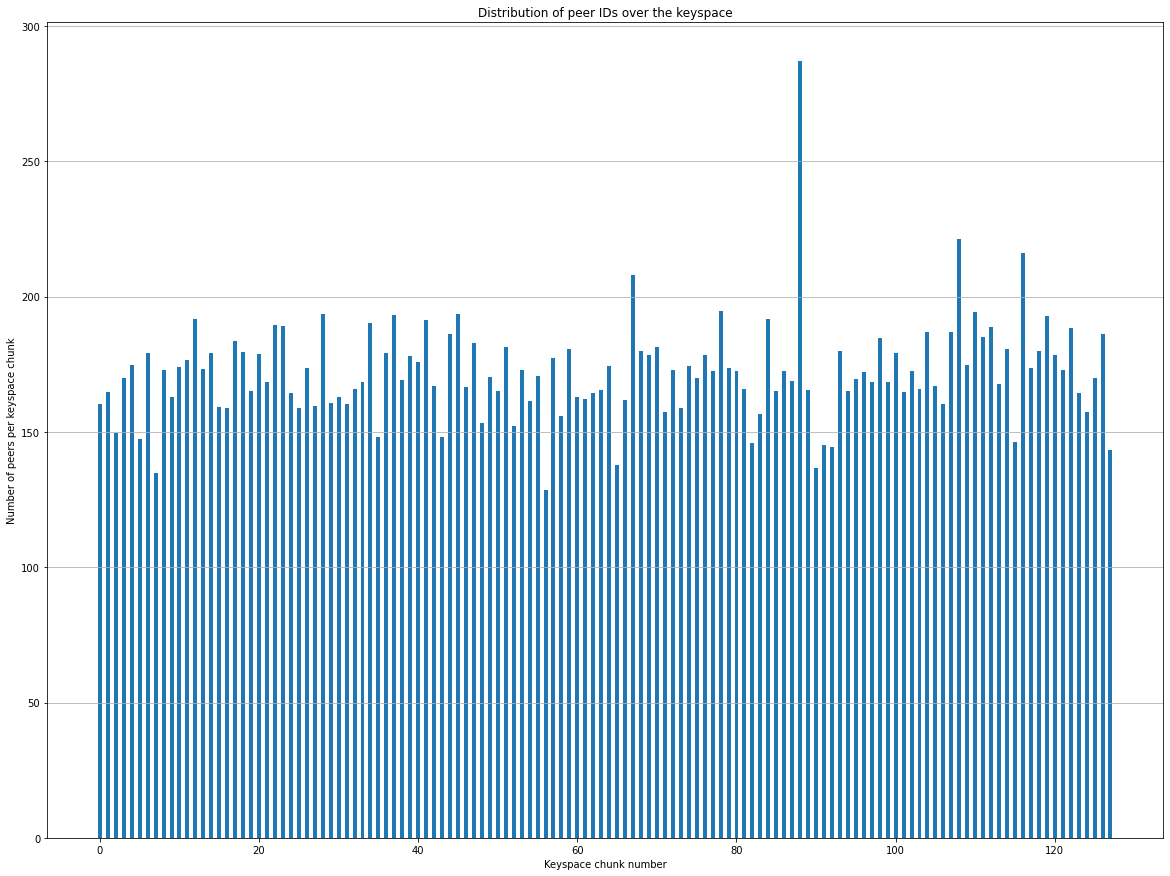

In [46]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/online-peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [47]:
density88 = np.average(peerids_distribution_chunk88_data, axis=0)

In [61]:
print("       prefix : occurences\n")
for i in range(len(density88)):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(4-len(path))+path
    path=int_to_bitstring(88,7)+path
    
    print(path+":", int(density88[i]))

       prefix : occurences

10110000000: 8
10110000001: 15
10110000010: 11
10110000011: 9
10110000100: 16
10110000101: 13
10110000110: 17
10110000111: 13
10110001000: 21
10110001001: 92
10110001010: 10
10110001011: 13
10110001100: 12
10110001101: 11
10110001110: 13
10110001111: 10


In [49]:
print("Average:            ", round(np.average(density88),2))
print("Standard deviation:  ", round(np.std(density88, ddof=1),2))
print("Max:                ", max(density88))
print("Min:                ", min(density88))

Average:             17.94
Standard deviation:   20.03
Max:                 92.0
Min:                 8.0


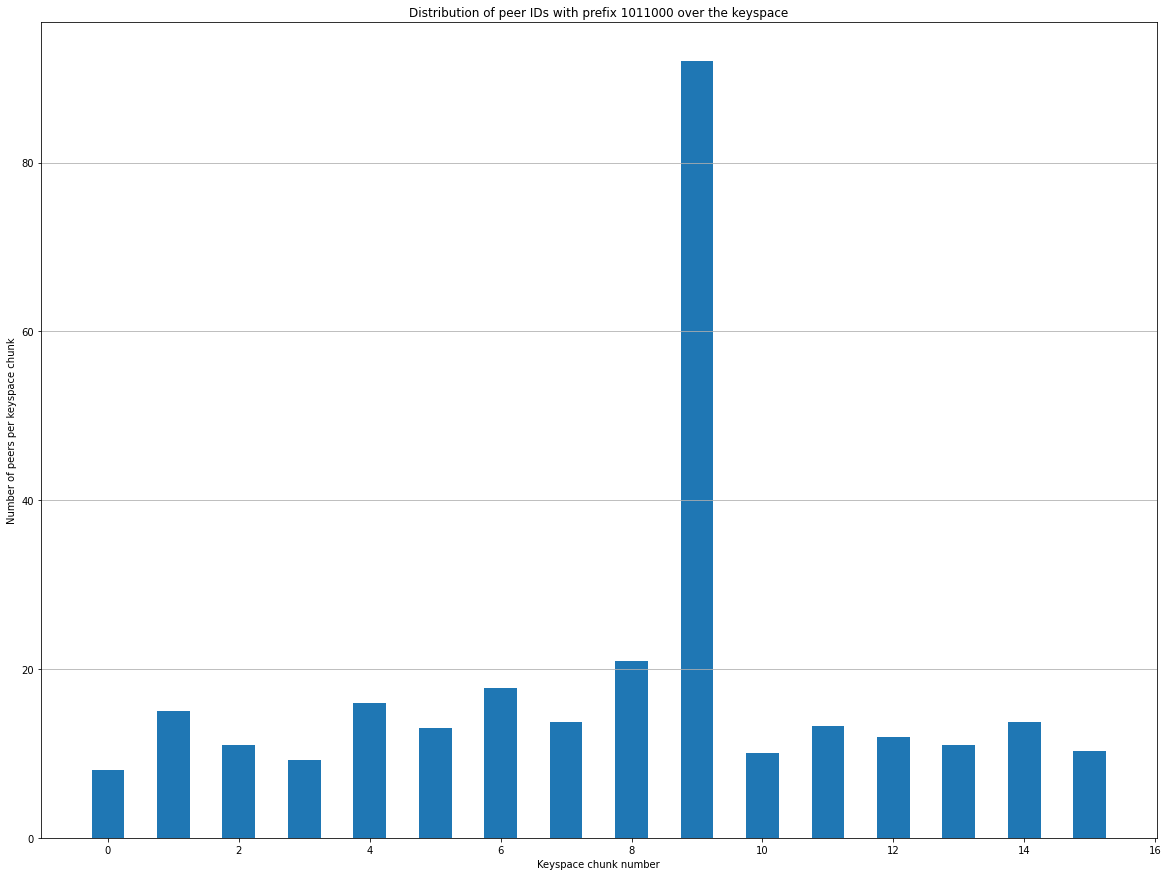

In [50]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs with prefix 1011000 over the keyspace")

plt.bar([x for x in range(len(density88))], density88, width=0.5)

plt.savefig('plots/online-peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

## PeerID distribution over keyspace (all times)

In [51]:
startTime = time.time()
peerids = [bytes_to_bitstring(multihash_to_kad_id(nebula_peerids[m])) for m in nebula_peerids]
print(time.time() - startTime)

6.141035318374634


In [52]:
startTime = time.time()
t = Trie()
for p in peerids:
    t.add(p)
print(time.time() - startTime)

7.097044229507446


In [53]:
levels=7
density=[0]*2**levels

In [54]:
startTime = time.time()
for i in range(2**levels):
    path="{0:b}".format(i)
    path='0'*(levels-len(path))+path
    
    density[i]=t.find_trie(path).size
print(time.time() - startTime)

0.0005078315734863281


In [55]:
print("Average:            ", round(np.average(density),2))
print("Standard deviation:   ", round(np.std(density, ddof=1),2))
print("Max:                ", max(density))
print("Min:                ", min(density))

Average:             3419.62
Standard deviation:    69.83
Max:                 3632
Min:                 3199


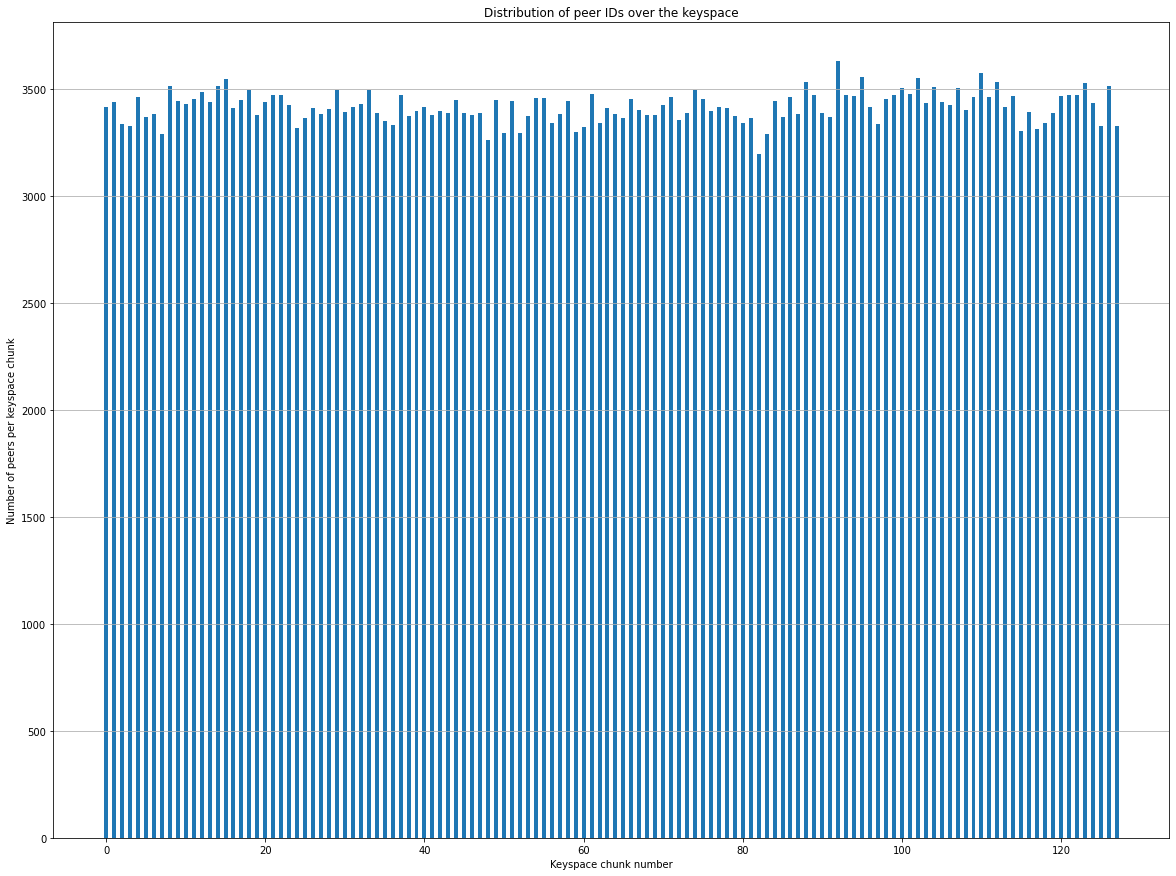

In [56]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

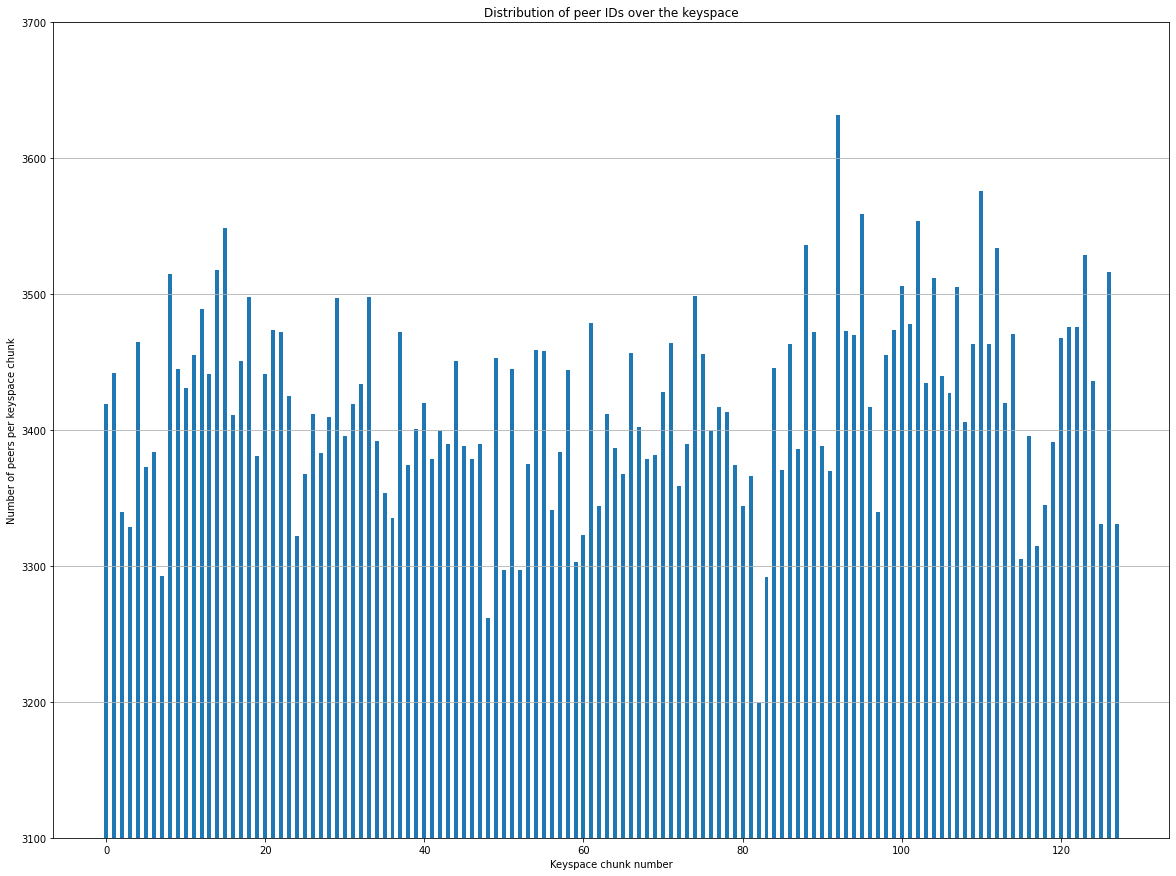

In [57]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.ylim(top=3700, bottom=3100)
plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [58]:
levels88_global = 4
density88_global = [0] * 2**levels88_global
for i in range(2**levels88_global):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(levels88_global-len(path))+path # zero padding for constant size bitstring
    path=int_to_bitstring(88,7)+path

    for p in peerids:
        if p[:len(path)] == path:
            density88_global[i]+=1



In [62]:
print("       prefix : occurences\n")
for i in range(len(density88_global)):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(4-len(path))+path
    path=int_to_bitstring(88,7)+path
    
    print(path+":", int(density88_global[i]))

       prefix : occurences

10110000000: 228
10110000001: 207
10110000010: 226
10110000011: 223
10110000100: 226
10110000101: 196
10110000110: 215
10110000111: 212
10110001000: 206
10110001001: 269
10110001010: 241
10110001011: 219
10110001100: 239
10110001101: 191
10110001110: 228
10110001111: 210


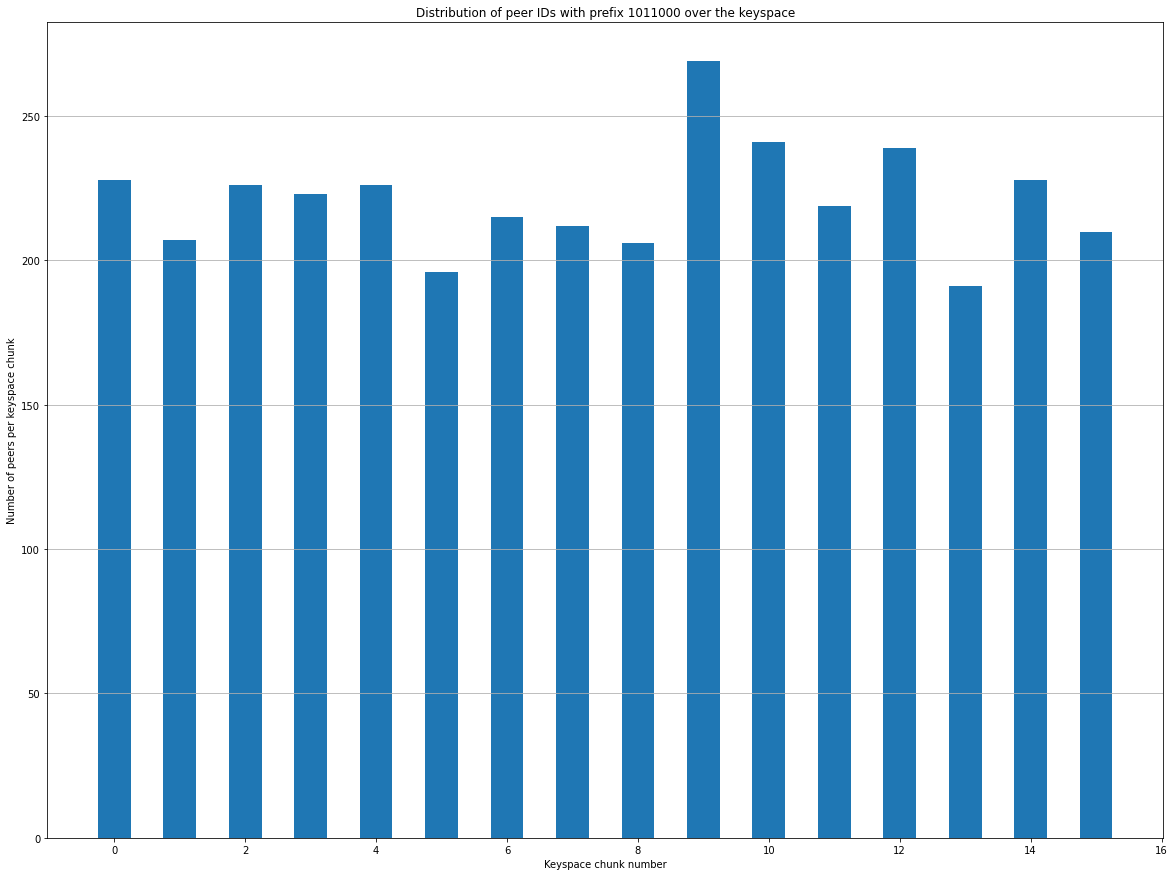

In [60]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs with prefix 1011000 over the keyspace")

plt.bar([x for x in range(len(density88_global))], density88_global, width=0.5)

plt.savefig('plots/online-peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()